In [2]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

### Loading dataset

In [3]:
# number of class
n_class = 5

# path to kaggle dataset
root_path = "./PreprocessedAll5/"

# list of folders
folder_list = os.listdir(root_path)
image_path_list = []
label_list = []

# for each folder, get the image path and labels
for folder in folder_list:
    for label in range(n_class):
        
        # get all the images path inside the current folder
        image_list = os.listdir(f"{root_path}{folder}/{label}")
        # add to the image path list
        image_path_list += [ f"{root_path}{folder}/{label}/"+ path for path in image_list]
        
        # add labels to the label list
        label_list += [label] * len(image_list)

# convert to dataframe
df_train_kaggle = pd.DataFrame({"filepath" : image_path_list, "label": label_list})
print(df_train_kaggle.shape)

(9786, 2)


Text(0, 0.5, 'count')

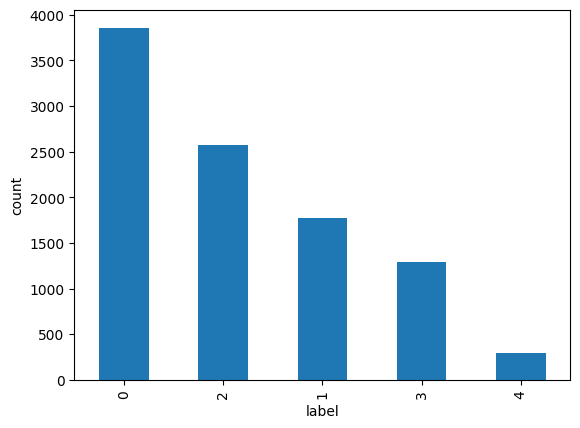

In [4]:
df_train_kaggle.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

We can see class imbalance here in the data

In [5]:
# train data generator object
train_aug = ImageDataGenerator(rescale=1./255)

# validation data generator object
valid_aug = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_aug.flow_from_dataframe(
dataframe=df_train_kaggle,
directory=None,
x_col="filepath",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

Found 9786 validated image filenames.


### Preparing validation and test data

In [7]:
compi_root_path= "./PreprocessedValidation/"
df_val_compi = pd.read_csv(compi_root_path + "Train.csv")

# add absolute path to the image names
df_val_compi["filename"] = df_val_compi.filename.apply(lambda x: compi_root_path+"train/" + x)
df_val_compi.head()

,filename,label
0,./PreprocessedValidation/train/Image_1.jpg,0
1,./PreprocessedValidation/train/Image_2.jpg,1
2,./PreprocessedValidation/train/Image_3.jpg,0
3,./PreprocessedValidation/train/Image_4.jpg,1
4,./PreprocessedValidation/train/Image_5.jpg,2


Text(0, 0.5, 'count')

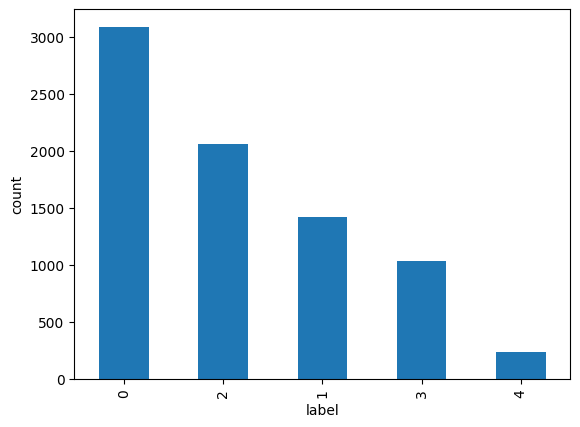

In [8]:
df_val_compi.label.value_counts().plot.bar()
plt.xlabel("label")
plt.ylabel("count")

In [9]:
# Step 1: Split validation data into x_val and x_test
x_val, x_test = train_test_split(df_val_compi, test_size=0.35, random_state=42)

# Create separate generators for x_val and x_test
val_generator = valid_aug.flow_from_dataframe(
    dataframe=x_val,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

test_generator = valid_aug.flow_from_dataframe(
    dataframe=x_test,
    x_col="filename",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=False,  # No need to shuffle for evaluation
    class_mode="raw",
    target_size=(224, 224)
)

Found 5088 validated image filenames.
Found 2740 validated image filenames.


### Baseline Model - VGG19 with basic transfer learning

In [10]:
# Load pre-trained VGG19 model with ImageNet weights
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Combine the base model with custom classification head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,156,997 (76.89 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
# training the model

hist=model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

c:\Users\aliir\anaconda3\envs\nlpllm\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1808s 6s/step - accuracy: 0.3750 - loss: 1.4256 - val_accuracy: 0.4114 - val_loss: 1.3997
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1052s 3s/step - accuracy: 0.4011 - loss: 1.3894 - val_accuracy: 0.4092 - val_loss: 1.4219
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - accuracy: 0.4110 - loss: 1.3677 - val_accuracy: 0.4125 - val_loss: 1.4168
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 770s 3s/step - accuracy: 0.4188 - loss: 1.3517 - val_accuracy: 0.3911 - val_loss: 1.4381
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 761s 2s/step - accuracy: 0.4099 - loss: 1.3447 - val_accuracy: 0.4043 - val_loss: 1.4540
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.4257 - loss: 1.3353 - val_accuracy: 0.3571 - val_loss: 1.4815
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 752s 2s/step - accuracy: 0.4234 - loss: 1.3335 - val_accuracy: 0.3939 - val_loss: 1.4415
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.4348 - loss: 1.3087 - val_ac

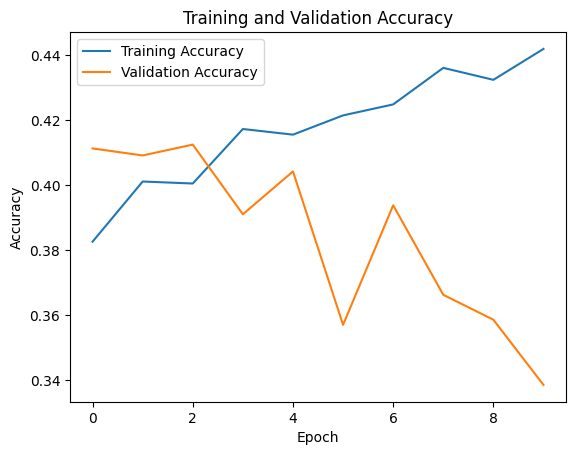

In [12]:
# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

86/86 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step
Confusion Matrix:
[[406   0 682   9   0]
 [153   0 333   5   1]
 [214   0 498  20   1]
 [ 99   0 200  35   2]
 [ 17   0  38  23   4]]


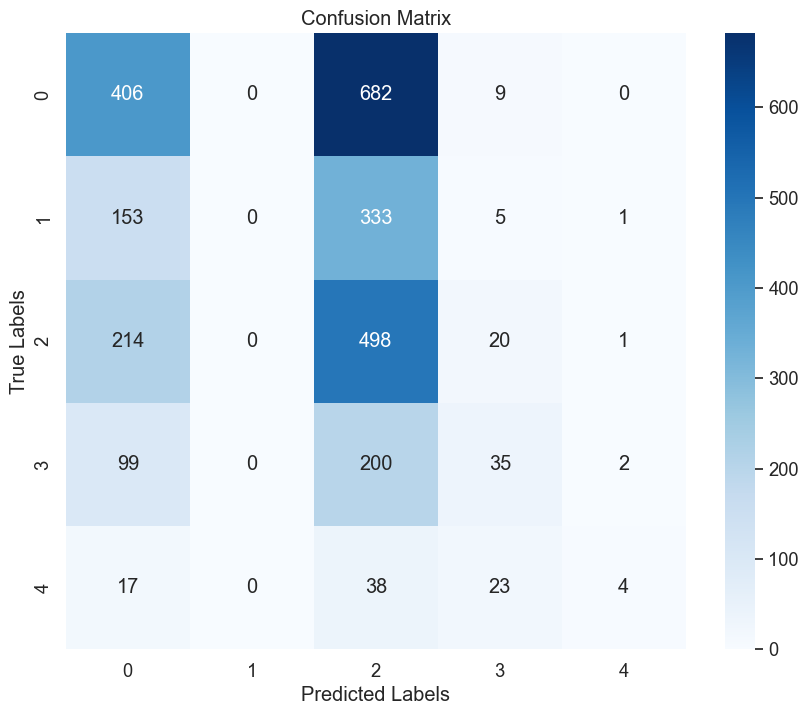

In [13]:
# Step 2: Use your model to predict labels for x_test
predictions = model.predict(test_generator)

# Step 3: Evaluate the predictions using a confusion matrix
true_labels = x_test["label"].values
predicted_labels = predictions.argmax(axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
classes = unique_labels(true_labels, predicted_labels)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.37      0.41      1097
           1       0.00      0.00      0.00       492
           2       0.28      0.68      0.40       733
           3       0.38      0.10      0.16       336
           4       0.50      0.05      0.09        82

    accuracy                           0.34      2740
   macro avg       0.32      0.24      0.21      2740
weighted avg       0.32      0.34      0.29      2740



c:\Users\aliir\anaconda3\envs\nlpllm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aliir\anaconda3\envs\nlpllm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aliir\anaconda3\envs\nlpllm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This classification report reveals performance difficulties in classifying classes as 
highlighted by the F1-scores. The significant class imbalance underscores the 
importance of the F1-score, which offers a more robust evaluation metric than accuracy 
alone. Epoch 8 likely represents the optimal training point; further iterations could 
lead to overfitting and reduced generalization performance. This pattern is reinforced by the 
confusion matrix, which emphasizes misclassifications within classes 1, 2, and 3. 
To enhance results, we'll be exploring alternative feature engineering techniques, model 
architectures, or hyperparameter optimization.

In [16]:
# Saving the vgg19 model with the best checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Corrected checkpoint path
checkpoint_path = "vgg19_best.weights.h5"  # Ensure it ends with `.weights.h5`
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define callbacks
my_callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_acc',  # Ensure 'val_acc' exists in model metrics
                    verbose=1,
                    save_weights_only=True,
                    save_best_only=True,
                    mode="max"),
    EarlyStopping(monitor='val_loss',
                  patience=5,
                  verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                      patience=5,
                      verbose=1)
]